<a href="https://colab.research.google.com/github/Ninadrmore1999/ML-projects-/blob/main/Stocks_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In last class, we grouped the customers of Amazon. In this class, we have another interesting use-case. Let's jump into it.

## **Problem Statement: Building Stock Portfolios**

**Goal :** Creating pools of stocks that move together(similar characteristics) on one or more fundamental financial metric.

In previous lecture we studied about K-Means clustering and how we can use it for customer segmentation.

In today's lecture we'll study some other clustering techniques, why they are required, what are the limitations of K-Means, and we'll use all this knowledge to build stock portfolios.

Let's first have a look at the dataset that we'll be using.

#### **Dataset - Top 50 NSE stocks**

- Contains company's stock symbol
- Name, Industry and other details

Lets import the dependencies

In [ ]:
  import pandas as pd
  import numpy as np
  from matplotlib import pyplot as plt
  plt.rcParams["figure.figsize"] = (18,10)
  import seaborn as sns

Reading the data

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb" -O ind_nifty50list.csv

--2023-12-05 11:47:35--  https://drive.google.com/uc?export=download&id=1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb
Resolving drive.google.com (drive.google.com)... 172.253.122.101, 172.253.122.138, 172.253.122.139, ...
Connecting to drive.google.com (drive.google.com)|172.253.122.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lor2e82k513o17ceehrjj71a7p7kujcr/1701776850000/10306167880925931714/*/1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb?e=download&uuid=911343ca-787d-4b5d-9b3e-7d06eb92c8cf [following]
--2023-12-05 11:47:35--  https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lor2e82k513o17ceehrjj71a7p7kujcr/1701776850000/10306167880925931714/*/1giO5bbp3l0INVvTQIGJ7s_Ai5_TWNuIb?e=download&uuid=911343ca-787d-4b5d-9b3e-7d06eb92c8cf
Resolving doc-08-64-docs.googleusercontent.com (doc-08-64-docs.googleusercontent.com)... 172.253.63.132, 2

**Installing yfinance**


- **yfinance** is a library that helps us download market data from yahoo finance's api.

- So lets install these libraries into our environment using pip.

- You can read more about it <a href="https://pypi.org/project/yfinance/"> here </a>


In [ ]:
!pip install yfinance

In [ ]:
# Since yfinance is an old library, it also has some glitches, so we install this library as a fix
!pip install fix-yahoo-finance

  Preparing metadata (setup.py) ... done
  Created wheel for fix-yahoo-finance: filename=fix_yahoo_finance-0.1.37-py3-none-any.whl size=7073 sha256=1b09fea22339face647b9afcbc1156a59c90c2ace6d0121a11f2afc2f3df0da7
  Stored in directory: /root/.cache/pip/wheels/1e/5e/ca/d9dbe97f5c895289286a5f99311e9e9633c9898f35d42802ca
Successfully built fix-yahoo-finance


#### EDA
#### **Importing Data**

- Purpose of this dataset: Getting list of Company names which are stored in the 'Symbol' column of the data

In [ ]:
stocks_df = pd.read_csv("./ind_nifty50list.csv")
list_of_symbols = list(stocks_df['Symbol'])
stocks_df.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042
1,Asian Paints Ltd.,CONSUMER GOODS,ASIANPAINT,EQ,INE021A01026
2,Axis Bank Ltd.,FINANCIAL SERVICES,AXISBANK,EQ,INE238A01034
3,Bajaj Auto Ltd.,AUTOMOBILE,BAJAJ-AUTO,EQ,INE917I01010
4,Bajaj Finance Ltd.,FINANCIAL SERVICES,BAJFINANCE,EQ,INE296A01024


**Now, we'll take symbols from original dataset**
- We'll add `.NS` at the end of every symbol to fetch data from Yahoo Finance based on company's symbol.

In [ ]:
yf_symbols = list(map(lambda x: x + '.NS', list_of_symbols))
yf_symbols

['ADANIPORTS.NS',
 'ASIANPAINT.NS',
 'AXISBANK.NS',
 'BAJAJ-AUTO.NS',
 'BAJFINANCE.NS',
 'BAJAJFINSV.NS',
 'BPCL.NS',
 'BHARTIARTL.NS',
 'BRITANNIA.NS',
 'CIPLA.NS',
 'COALINDIA.NS',
 'DIVISLAB.NS',
 'DRREDDY.NS',
 'EICHERMOT.NS',
 'GRASIM.NS',
 'HCLTECH.NS',
 'HDFCBANK.NS',
 'HDFCLIFE.NS',
 'HEROMOTOCO.NS',
 'HINDALCO.NS',
 'HINDUNILVR.NS',
 'HDFC.NS',
 'ICICIBANK.NS',
 'ITC.NS',
 'IOC.NS',
 'INDUSINDBK.NS',
 'INFY.NS',
 'JSWSTEEL.NS',
 'KOTAKBANK.NS',
 'LT.NS',
 'M&M.NS',
 'MARUTI.NS',
 'NTPC.NS',
 'NESTLEIND.NS',
 'ONGC.NS',
 'POWERGRID.NS',
 'RELIANCE.NS',
 'SBILIFE.NS',
 'SHREECEM.NS',
 'SBIN.NS',
 'SUNPHARMA.NS',
 'TCS.NS',
 'TATACONSUM.NS',
 'TATAMOTORS.NS',
 'TATASTEEL.NS',
 'TECHM.NS',
 'TITAN.NS',
 'UPL.NS',
 'ULTRACEMCO.NS',
 'WIPRO.NS']

**Now, we'll define some variables and fetch the corresponding data from Yahoo Finance for the companies in our list**

In [ ]:
import yfinance as yf


stock_financials = {
    'marketCap': [],
    'regularMarketVolume': [],
    'earningsQuarterlyGrowth': [],
    'bookValue': [],
    'totalRevenue': [],
    'returnOnAssets': [],
    'profitMargins': [],
    'earningsGrowth': []
    }

for ticker in yf_symbols:
    stock_info = yf.Ticker(ticker).info
    stock_financials['marketCap'].append(stock_info.get('marketCap', None))
    stock_financials['regularMarketVolume'].append(stock_info.get('regularMarketVolume', None))
    stock_financials['earningsQuarterlyGrowth'].append(stock_info.get('earningsQuarterlyGrowth', None))
    stock_financials['bookValue'].append(stock_info.get('bookValue', None))
    stock_financials['totalRevenue'].append(stock_info.get('totalRevenue', None))
    stock_financials['returnOnAssets'].append(stock_info.get('returnOnAssets', None))
    stock_financials['profitMargins'].append(stock_info.get('profitMargins', None))
    stock_financials['earningsGrowth'].append(stock_info.get('earningsGrowth', None))

**Q. What have we collected?**
We 've collected attributes such as '**marketCap**', '**regularMarketVolume**' and others for companies that we collected in variable '**yf_symbols**'

In [ ]:
df = pd.DataFrame(stock_financials)
df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth
0,2188680888320,46551402,0.042,225.380,234769793024,0.06029,0.26992,0.041
1,3093463826432,1005428,0.540,172.706,350244601856,0.15803,0.14454,0.540
2,3492905746432,15804267,0.105,462.233,595522813952,0.01024,0.22033,0.104
3,1738753572864,565798,0.175,1036.725,403337510912,0.14867,0.16963,0.188
4,4538435108864,1522179,0.277,989.308,287215910912,0.04705,0.45675,0.276


In [ ]:
df.shape

(50, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   marketCap                50 non-null     int64  
 1   regularMarketVolume      50 non-null     int64  
 2   earningsQuarterlyGrowth  44 non-null     float64
 3   bookValue                49 non-null     float64
 4   totalRevenue             50 non-null     int64  
 5   returnOnAssets           46 non-null     float64
 6   profitMargins            50 non-null     float64
 7   earningsGrowth           44 non-null     float64
dtypes: float64(5), int64(3)
memory usage: 3.2 KB


**Downloading stock price data**
- Purpose of this data: Getting returns of the stocks

In [ ]:
import yfinance as yf

stock_prices = yf.download(yf_symbols, start='2020-01-01')['Adj Close']
stock_prices.columns = list_of_symbols

[*********************100%%**********************]  50 of 50 completed


 - 'Adj Close' refers to Adjusted close which is used in stock market. It is the closing price after adjustments for all applicable splits and dividend distributions

In [ ]:
stock_prices.shape

(975, 50)

In [ ]:
stock_prices.tail()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,BRITANNIA,CIPLA,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-29,835.549988,3148.350098,1060.150024,6069.950195,1653.500000,7130.100098,995.400024,428.649994,4803.649902,1201.550049,...,1202.199951,933.549988,712.349976,127.750000,3513.750000,1221.699951,3429.300049,8732.750000,570.049988,406.250000
2023-11-30,825.500000,3119.899902,1074.250000,6090.549805,1673.500000,7121.899902,1014.700012,435.700012,4852.649902,1212.300049,...,1225.849976,940.750000,706.400024,127.900002,3487.600098,1220.949951,3490.600098,9003.650391,570.650024,413.049988
2023-12-01,827.799988,3173.399902,1104.650024,6046.049805,1685.949951,7259.350098,1014.700012,438.000000,4970.750000,1205.699951,...,1231.250000,942.849976,705.450012,130.000000,3511.649902,1220.550049,3489.500000,9033.849609,575.150024,407.649994
2023-12-04,878.650024,3194.550049,1125.599976,6201.700195,1696.250000,7407.649902,1032.900024,461.500000,4937.750000,1216.500000,...,1231.150024,946.650024,705.599976,131.000000,3512.449951,1223.900024,3488.399902,9317.750000,578.900024,407.450012
2023-12-05,1013.099976,3226.250000,1132.449951,6140.100098,1692.699951,7349.799805,1031.099976,472.200012,4948.399902,1224.449951,...,1239.550049,950.049988,708.950012,131.600006,3531.600098,1220.599976,3545.300049,9329.750000,581.400024,404.350006


In [ ]:
# splitting data by year - 2020 returns
price_2020 = stock_prices.loc["2020-01-02 00:00:00":"2020-12-31 00:00:00"]

# to see % growth of the stock: ((endDate/startDate) - 1) * 100
stock_prices.loc['returns_2020'] = (price_2020.loc['2020-08-04 00:00:00'] / price_2020.loc['2020-01-02 00:00:00'] - 1)*100

stock_prices

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,BRITANNIA,CIPLA,...,SUNPHARMA,TCS,TATACONSUM,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,WIPRO
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,365.911560,1743.498413,746.799988,2640.764648,935.770386,4163.675293,447.652771,389.949921,2787.020508,466.001099,...,416.195679,313.626343,183.876907,40.974754,2008.583374,642.186279,1139.831055,3991.287109,557.155457,243.122696
2020-01-02 00:00:00,371.240601,1741.019165,755.029053,2616.369629,948.457336,4178.189453,449.529114,386.697968,2799.627441,463.651001,...,416.818604,313.142120,193.148010,42.472710,1999.363159,645.514709,1140.670044,4167.826660,563.974792,243.711609
2020-01-03 00:00:00,370.610809,1702.856934,741.064575,2575.334717,932.517639,4126.430664,449.430359,383.485748,2786.241211,460.174866,...,426.066376,308.154694,190.506256,42.371967,2039.207886,653.140808,1124.975464,4142.691406,559.523315,246.459885
2020-01-06 00:00:00,368.382263,1659.833740,721.414551,2546.496338,902.269775,3932.824707,444.048248,372.104095,2770.883545,457.041412,...,421.610199,302.247284,185.073181,41.456551,2039.022583,649.180359,1143.631348,4081.717285,554.029846,247.490463
2020-01-07 00:00:00,372.839264,1676.605469,723.908203,2546.748047,907.553040,3943.599854,439.554962,365.639984,2784.224121,458.852936,...,427.791321,304.958862,184.126129,41.706215,2044.027222,654.826111,1144.963867,4165.175781,563.595886,250.484100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30 00:00:00,825.500000,3119.899902,1074.250000,6090.549805,1673.500000,7121.899902,1014.700012,435.700012,4852.649902,1212.300049,...,1225.849976,940.750000,706.400024,127.900002,3487.600098,1220.949951,3490.600098,9003.650391,570.650024,413.049988
2023-12-01 00:00:00,827.799988,3173.399902,1104.650024,6046.049805,1685.949951,7259.350098,1014.700012,438.000000,4970.750000,1205.699951,...,1231.250000,942.849976,705.450012,130.000000,3511.649902,1220.550049,3489.500000,9033.849609,575.150024,407.649994
2023-12-04 00:00:00,878.650024,3194.550049,1125.599976,6201.700195,1696.250000,7407.649902,1032.900024,461.500000,4937.750000,1216.500000,...,1231.150024,946.650024,705.599976,131.000000,3512.449951,1223.900024,3488.399902,9317.750000,578.900024,407.450012


In [ ]:
stock_prices = stock_prices.transpose()
stock_prices.head()

Date,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,2020-01-13 00:00:00,2020-01-14 00:00:00,...,2023-11-22 00:00:00,2023-11-23 00:00:00,2023-11-24 00:00:00,2023-11-28 00:00:00,2023-11-29 00:00:00,2023-11-30 00:00:00,2023-12-01 00:00:00,2023-12-04 00:00:00,2023-12-05 00:00:00,returns_2020
ADANIPORTS,365.911560,371.240601,370.610809,368.382263,372.839264,373.662872,379.621674,379.863953,378.216797,377.102539,...,791.900024,793.099976,795.549988,837.700012,835.549988,825.500000,827.799988,878.650024,1013.099976,-16.891375
ASIANPAINT,1743.498413,1741.019165,1702.856934,1659.833740,1676.605469,1680.883423,1723.421021,1742.866577,1754.874146,1768.729370,...,3133.000000,3122.949951,3136.149902,3148.350098,3148.350098,3119.899902,3173.399902,3194.550049,3226.250000,-3.813719
AXISBANK,746.799988,755.029053,741.064575,721.414551,723.908203,722.661377,740.964844,738.171997,735.528687,746.002014,...,998.099976,999.049988,1008.500000,1021.150024,1060.150024,1074.250000,1104.650024,1125.599976,1132.449951,-43.305368
BAJAJ-AUTO,2640.764648,2616.369629,2575.334717,2546.496338,2546.748047,2564.604004,2586.777344,2599.771240,2593.777344,2600.106689,...,5751.549805,5925.250000,5930.299805,5998.149902,6069.950195,6090.549805,6046.049805,6201.700195,6140.100098,-0.566446
BAJFINANCE,935.770386,948.457336,932.517639,902.269775,907.553040,912.526978,937.446777,935.151794,943.433472,953.371460,...,1623.900024,1623.949951,1617.250000,1654.400024,1653.500000,1673.500000,1685.949951,1696.250000,1692.699951,-35.138667


**Putting the data together**

In [ ]:
prices = stock_prices.iloc[:, -1]
df.index = stock_prices.index
df['return_2020'] = prices
df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020
ADANIPORTS,2188680888320,46551402,0.042,225.380,234769793024,0.06029,0.26992,0.041,-16.891375
ASIANPAINT,3093463826432,1005428,0.540,172.706,350244601856,0.15803,0.14454,0.540,-3.813719
AXISBANK,3492905746432,15804267,0.105,462.233,595522813952,0.01024,0.22033,0.104,-43.305368
BAJAJ-AUTO,1738753572864,565798,0.175,1036.725,403337510912,0.14867,0.16963,0.188,-0.566446
BAJFINANCE,4538435108864,1522179,0.277,989.308,287215910912,0.04705,0.45675,0.276,-35.138667


**Checking for null values**

In [ ]:
df.isna().sum()

marketCap                  0
regularMarketVolume        0
earningsQuarterlyGrowth    6
bookValue                  1
totalRevenue               0
returnOnAssets             4
profitMargins              0
earningsGrowth             6
return_2020                1
dtype: int64

In [ ]:
df['returnOnAssets'] = df['returnOnAssets'].replace(np.nan, 0)

In [ ]:
df.dropna(axis=0, inplace=True)
df.shape

(42, 9)

In [ ]:
df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020
ADANIPORTS,2188680888320,46551402,0.042,225.380,234769793024,0.06029,0.26992,0.041,-16.891375
ASIANPAINT,3093463826432,1005428,0.540,172.706,350244601856,0.15803,0.14454,0.540,-3.813719
AXISBANK,3492905746432,15804267,0.105,462.233,595522813952,0.01024,0.22033,0.104,-43.305368
BAJAJ-AUTO,1738753572864,565798,0.175,1036.725,403337510912,0.14867,0.16963,0.188,-0.566446
BAJFINANCE,4538435108864,1522179,0.277,989.308,287215910912,0.04705,0.45675,0.276,-35.138667


**Q. Should we Scale the values?**

- The data seems to be in different scales
- Different financial metrics have different scales.
- We need to put them on the same scale.

We can use `StandardScaler` from `sklearn`

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)
X = scaler.transform(df)

In [ ]:
scaled_df = pd.DataFrame(X, columns=df.columns, index=df.index)

In [ ]:
scaled_df

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020
ADANIPORTS,-0.388733,3.058945,-0.517473,-0.436242,-0.545191,-0.237950,1.139351,-0.520369,-0.356203
ASIANPAINT,-0.094522,-0.569971,0.841576,-0.494960,-0.471767,1.471393,-0.145937,0.843380,0.099408
AXISBANK,0.035365,0.609140,-0.345545,-0.172211,-0.315810,-1.113258,0.630997,-0.348193,-1.276439
BAJAJ-AUTO,-0.535037,-0.604999,-0.154514,0.468201,-0.438009,1.307699,0.111264,-0.118624,0.212540
BAJFINANCE,0.375342,-0.528798,0.123845,0.415343,-0.511843,-0.469500,3.054572,0.121877,-0.991920
BAJAJFINSV,-0.224417,-0.508372,0.020143,-0.331751,-0.101116,-0.382756,-0.812262,-0.020237,-0.590700
BHARTIARTL,0.864656,-0.310175,-1.655473,-0.535439,0.235747,-0.323819,-1.098781,-1.681879,-0.172391
BRITANNIA,-0.712855,-0.627736,-0.110850,-0.555595,-0.588888,2.531207,-0.061878,-0.107692,1.152479
CIPLA,-0.778966,-0.480217,0.552301,-0.344697,-0.539699,0.478211,-0.173308,0.550953,2.014351
COALINDIA,-0.387927,0.607411,-0.290965,-0.561475,0.203757,0.354741,0.408547,-0.293533,-0.935149


#### Performing Agglomerative Clustering


In [ ]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch

# Refer https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
Z = sch.linkage(scaled_df, method='ward') #linkage = ward

In [ ]:
Z.shape

(41, 4)

In [ ]:
Z

array([[15.        , 32.        ,  0.77922048,  2.        ],
       [35.        , 41.        ,  0.88636062,  2.        ],
       [ 0.        , 30.        ,  0.96375042,  2.        ],
       [18.        , 23.        ,  0.97844033,  2.        ],
       [22.        , 24.        ,  1.18430109,  2.        ],
       [ 5.        , 39.        ,  1.20337308,  2.        ],
       [14.        , 43.        ,  1.29692692,  3.        ],
       [ 1.        , 12.        ,  1.49803141,  2.        ],
       [19.        , 34.        ,  1.52346723,  2.        ],
       [16.        , 49.        ,  1.5961426 ,  3.        ],
       [ 8.        , 11.        ,  1.61743363,  2.        ],
       [37.        , 47.        ,  1.62964605,  3.        ],
       [ 2.        ,  9.        ,  1.71102505,  2.        ],
       [13.        , 42.        ,  1.73725384,  3.        ],
       [17.        , 55.        ,  1.81980075,  4.        ],
       [ 3.        , 51.        ,  1.83151783,  4.        ],
       [25.        , 28.

Text(0, 0.5, 'distance')

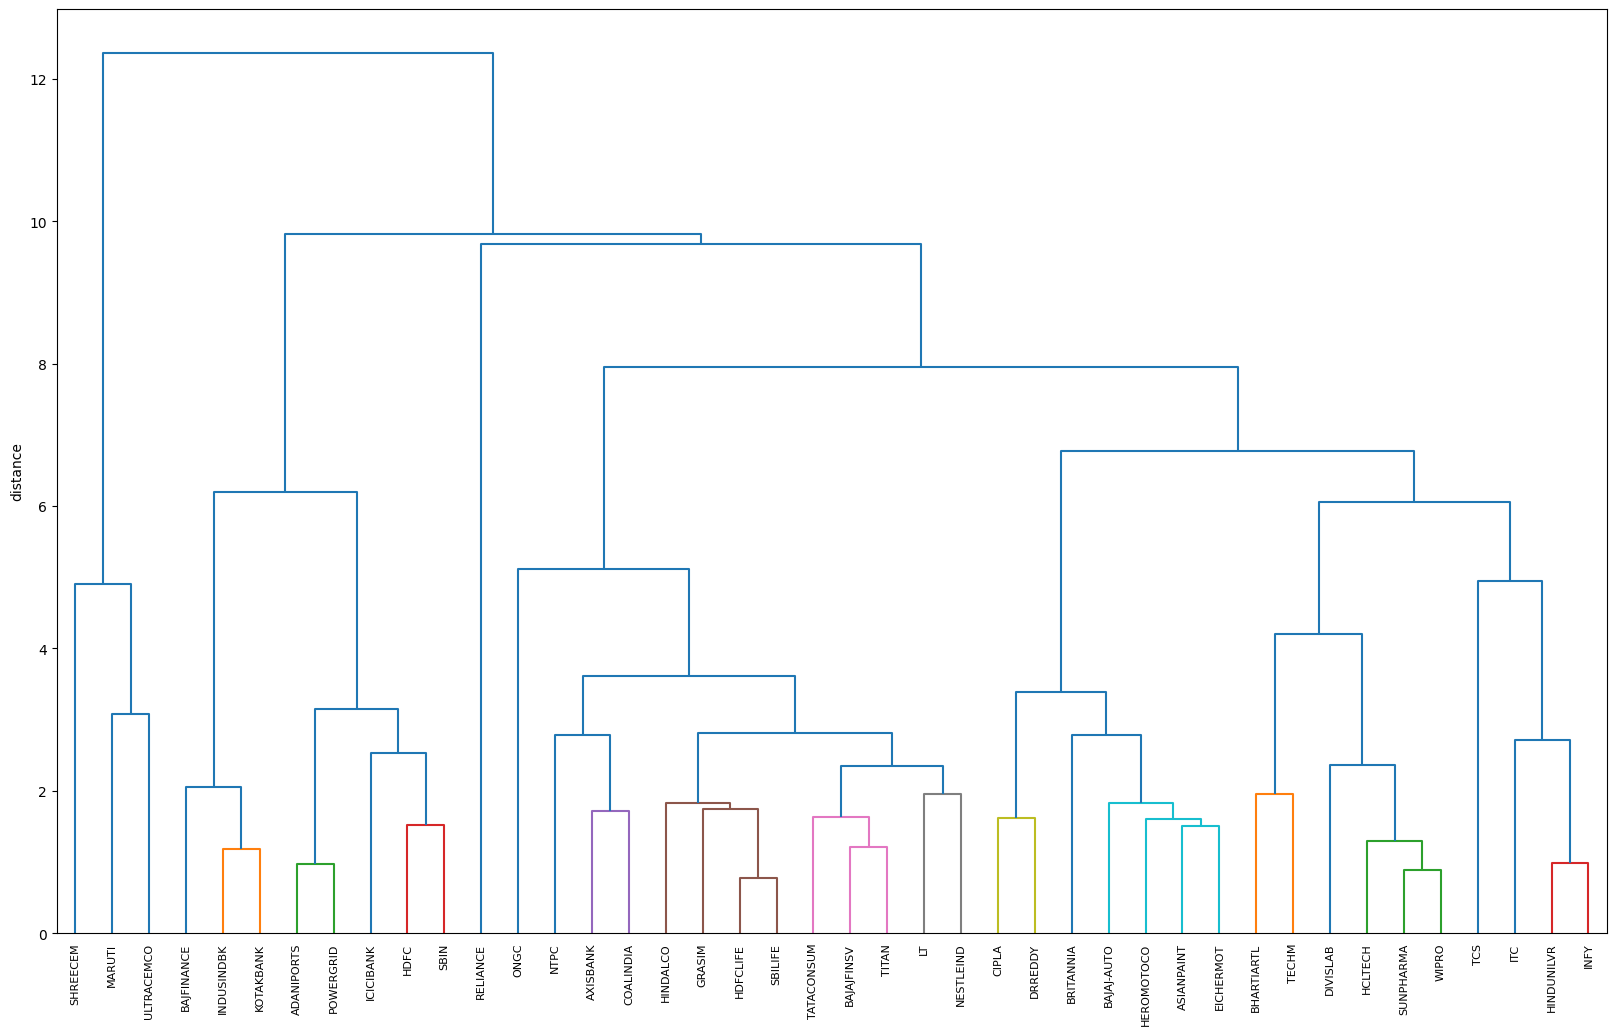

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=scaled_df.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

#### **Interpreting the Dendrogram**
- Note that we are now plotting companies that are similar to one another.
- The leaves of the tree correspond to the records.
- The length of the branch in the tree indicates the degree of dissimilarity between corresponding clusters.
- All the clusterings are made in the 8 dimensional space

#### **Insights**
- We may think that companies working in same field will have similar trends in stocks and will be clustered together.
- In some cases, this is right. For example, we can see that AXISBANK, HDFCBANK, BAJAJFINANCE will be grouped together.
- While in some cases, it is not. Such as chances of tech companies like TCS, WIPRO, TECHMAHINDRA grouping together are only when we set the number of clusters very low.

#### **Calculating the number of clusters**

Text(0, 0.5, 'distance')

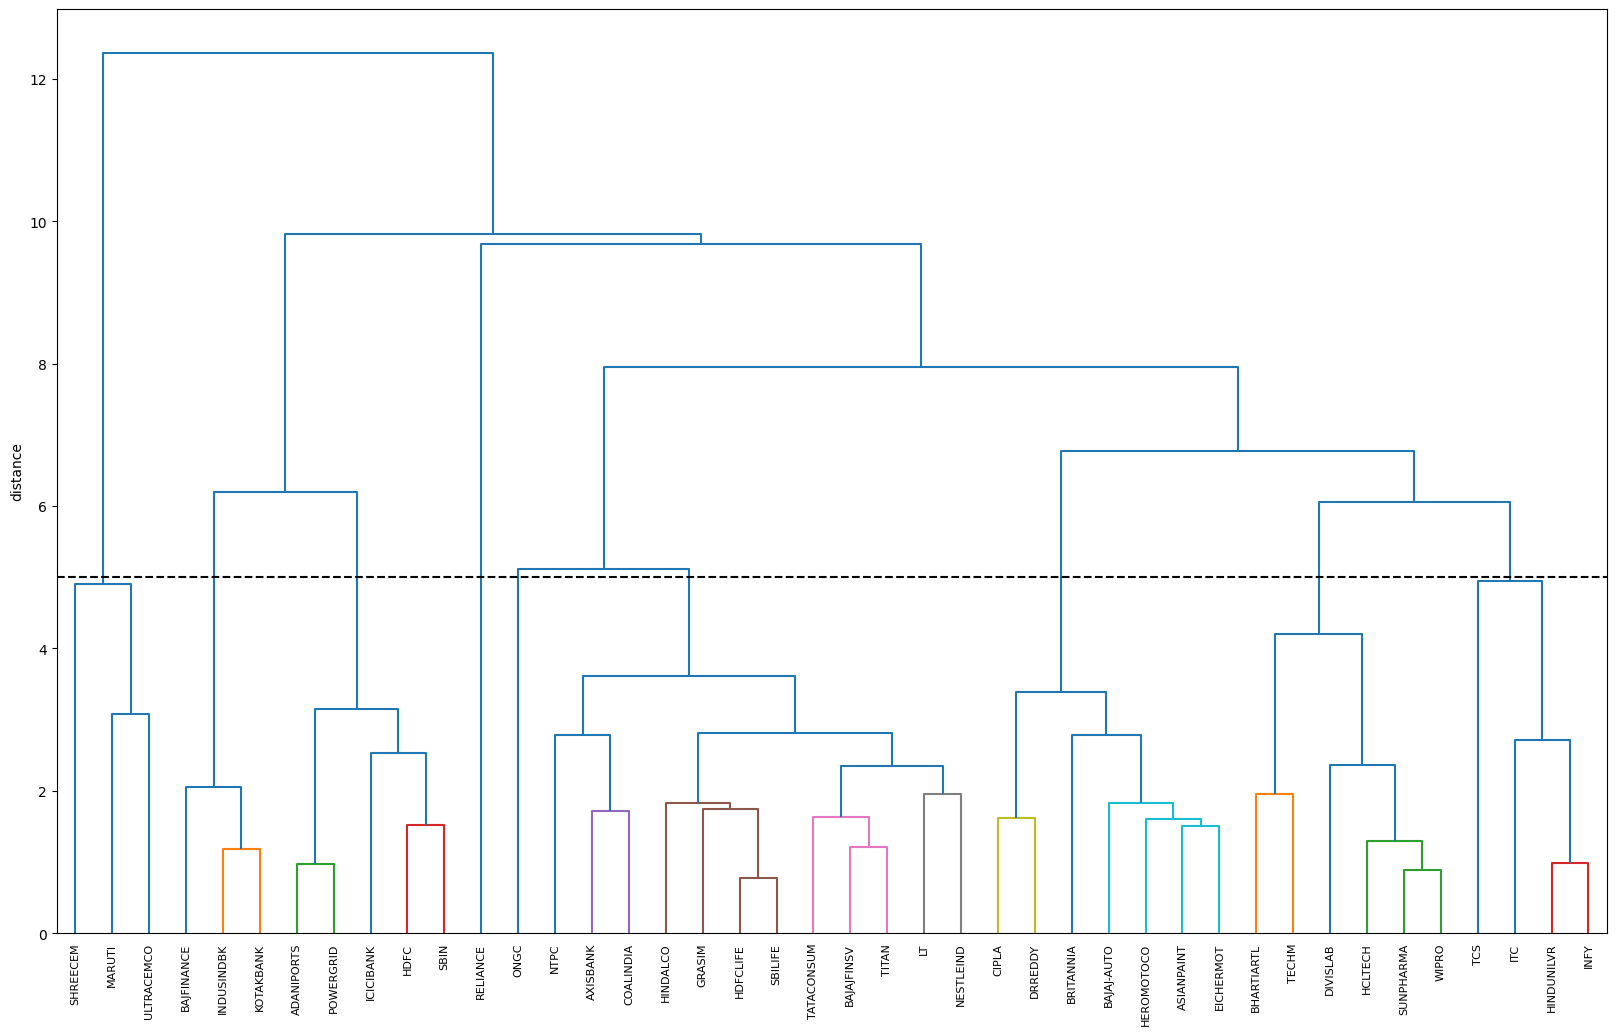

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=scaled_df.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
plt.axhline(y=5, color='k', linestyle='--')
ax.set_ylabel('distance')

#### **Performing Agglomerative Clustering with 5 clusters**

In [ ]:
# import hierarchical clustering libraries
from sklearn.cluster import AgglomerativeClustering


# create clusters
hc_2020 = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage = 'ward')
y_pred = hc_2020.fit_predict(scaled_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



In [ ]:
y_pred

array([2, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2, 2, 0,
       2, 0, 2, 1, 4, 1, 1, 1, 2, 3, 1, 4, 2, 0, 0, 1, 0, 1, 4, 0])

In [ ]:
viz_df = scaled_df
viz_df['Y_Predicted'] = y_pred

In [ ]:
viz_df.head()

,marketCap,regularMarketVolume,earningsQuarterlyGrowth,bookValue,totalRevenue,returnOnAssets,profitMargins,earningsGrowth,return_2020,Y_Predicted
ADANIPORTS,-0.388733,3.058945,-0.517473,-0.436242,-0.545191,-0.237950,1.139351,-0.520369,-0.356203,2
ASIANPAINT,-0.094522,-0.569971,0.841576,-0.494960,-0.471767,1.471393,-0.145937,0.843380,0.099408,0
AXISBANK,0.035365,0.609140,-0.345545,-0.172211,-0.315810,-1.113258,0.630997,-0.348193,-1.276439,1
BAJAJ-AUTO,-0.535037,-0.604999,-0.154514,0.468201,-0.438009,1.307699,0.111264,-0.118624,0.212540,0
BAJFINANCE,0.375342,-0.528798,0.123845,0.415343,-0.511843,-0.469500,3.054572,0.121877,-0.991920,2


##### **Plotting the characteristics of the learned clusters**

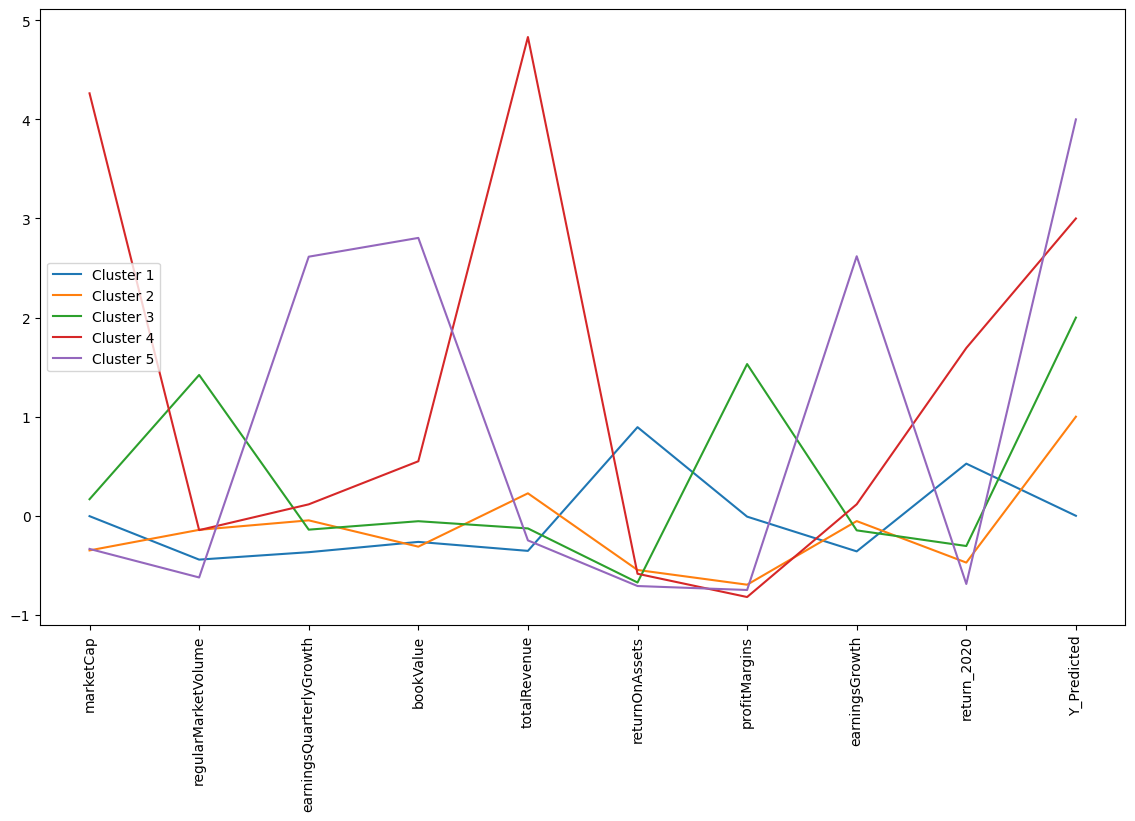

In [ ]:
#Plot a line graph to see the characteristics of the clusters
scaled_df['label'] = pd.Series(y_pred, index=scaled_df.index)

clustered_df = scaled_df.groupby('label').mean()

labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

plt.figure(figsize=(14,8))
plt.plot(clustered_df.T, label=labels)
plt.xticks(rotation=90)
plt.legend(labels)


##### **Looking at this, What characteristics do we find unique in each of these learned cluster?**

- **Cluster 1** - Companies with average market capital, quarterly growth, total revenue returning average returns

- **Cluster 2** - Companies havning largest market capital, with low quaterly growth (because they are already dominating), high total revenue, and highest return

- **Cluster 3** - Trader's favourites - high market volume with good profit margins.

- **Cluster 4** - Low market capital, with low quarterly growth, having high total revenue, with second largest returns

- **Cluster 5** - low market cap, with very high quarterly growth, but lowest total revenue and returns

This way, with the help of Hierarchical Clustering, we can draw conclusions on how different data points are grouped into different clusters, and also get information about the features of the dataset based on which the grouping is done.

***

#### Comparing Hierarchical Clustering with K-Means++

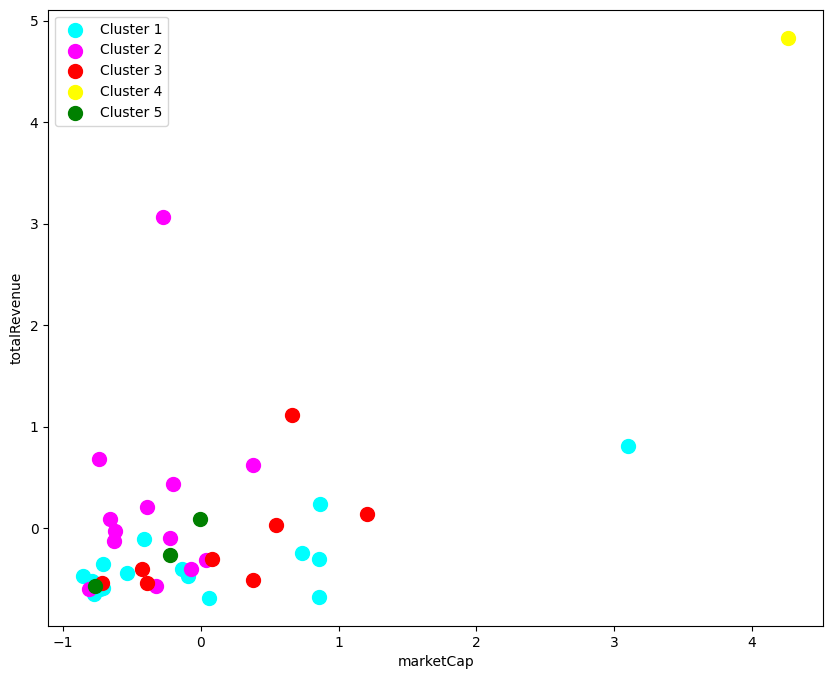

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['Y_Predicted'] == 0]['marketCap'], viz_df[viz_df['Y_Predicted'] == 0]['totalRevenue'], s=100, c='Cyan', label='Cluster 1')
plt.scatter(viz_df[viz_df['Y_Predicted'] == 1]['marketCap'], viz_df[viz_df['Y_Predicted'] == 1]['totalRevenue'], s=100, c='Magenta', label='Cluster 2')
plt.scatter(viz_df[viz_df['Y_Predicted'] == 2]['marketCap'], viz_df[viz_df['Y_Predicted'] == 2]['totalRevenue'], s=100, c='Red', label='Cluster 3')
plt.scatter(viz_df[viz_df['Y_Predicted'] == 3]['marketCap'], viz_df[viz_df['Y_Predicted'] == 3]['totalRevenue'], s=100, c='Yellow', label='Cluster 4')
plt.scatter(viz_df[viz_df['Y_Predicted'] == 4]['marketCap'], viz_df[scaled_df['Y_Predicted'] == 4]['totalRevenue'], s=100, c='Green', label='Cluster 5')
plt.xlabel('marketCap')
plt.ylabel('totalRevenue')
plt.legend()
plt.show()

From the dendogram one important thing we concluded was that we may think comanies in the same industries will have same stock figures, it is often the opposite.

From the clusters shown in the results of hierarchical clustering, you will observe that though points which are very close to each other belongs to other clusters.

This often happens in the real world and this is where KMeans/KMeans++ would not give effective results.

Let's also see K-Means++ results which would give more intuition.

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5, init = 'k-means++', random_state = 50)
y_km = km.fit_predict(scaled_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
viz_df['km_predicted'] = y_km

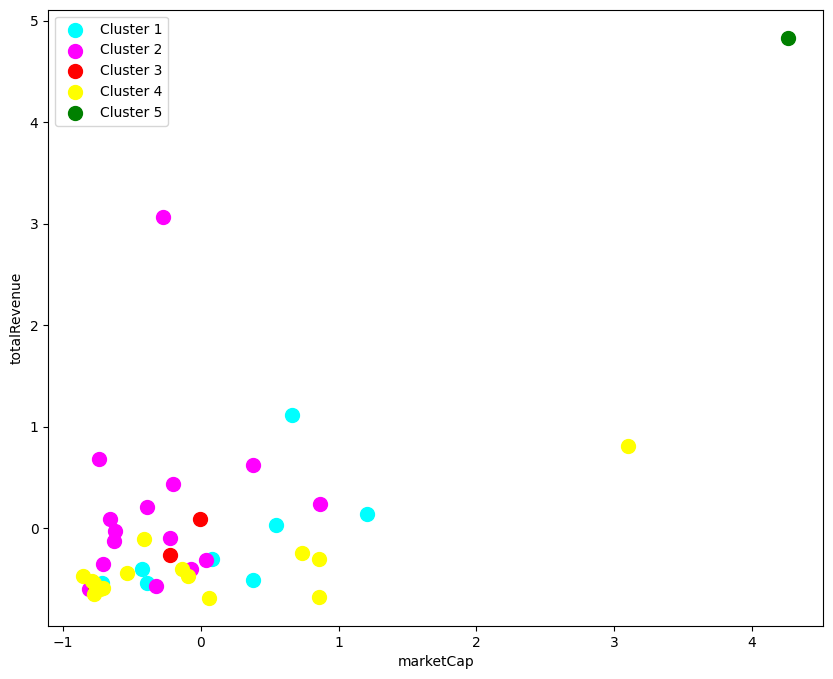

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(viz_df[viz_df['km_predicted'] == 0]['marketCap'], viz_df[viz_df['km_predicted'] == 0]['totalRevenue'], s=100, c='Cyan', label = 'Cluster 1')
plt.scatter(viz_df[viz_df['km_predicted'] == 1]['marketCap'], viz_df[viz_df['km_predicted'] == 1]['totalRevenue'], s=100, c='Magenta', label = 'Cluster 2')
plt.scatter(viz_df[viz_df['km_predicted'] == 2]['marketCap'], viz_df[viz_df['km_predicted'] == 2]['totalRevenue'], s=100, c='Red', label = 'Cluster 3')
plt.scatter(viz_df[viz_df['km_predicted'] == 3]['marketCap'], viz_df[viz_df['km_predicted'] == 3]['totalRevenue'], s=100, c='Yellow', label = 'Cluster 4')
plt.scatter(viz_df[viz_df['km_predicted'] == 4]['marketCap'], viz_df[scaled_df['km_predicted'] == 4]['totalRevenue'], s=100, c='Green', label = 'Cluster 5')

plt.xlabel('marketCap')
plt.ylabel('totalRevenue')
plt.legend()
plt.show()